# Importing and Cleaning Data
We start by importing the required packages

In [594]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as pyplot
from matplotlib import style
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

Then, we read the data into a pandas dataframe and add the columns. The data has already been split into test and train sets.

In [595]:
test_data = pd.read_csv("test.csv", sep = ",")
test_cols = test_data.columns.values
test_data = test_data[test_cols]
train_data = pd.read_csv("train.csv", sep = ",")
train_cols = train_data.columns.values
train_data = train_data[train_cols]

This is what the data looks like once its been read into a pandas dataframe

In [596]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Checking the attribute value type and number, it can be seen that there are 5 object attributes and 7 integer or float type attributes. As can be seen by the null count there are a large amount of null counts in the 'Cabin' column

In [597]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [598]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can remove the cabin column as it has too many NaNs as entries and the ticket columns as it most likely will not correlate to surviving.

In [599]:
dropped_cols = ["Cabin","Ticket"]
test_data.drop(columns = dropped_cols, inplace = True)
train_data.drop(columns = dropped_cols, inplace = True)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


# Testing Correlation

## Passenger Class
Now we want to test the correlation of each attribute to the survivability in the training data. We first look at the mean probability of surviving for each passenger class.

In [600]:
train_data[['Pclass','Survived']].groupby(['Pclass']).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


## Sex

As can be expected the first class passengers had the heighest chances of survival, with the majority of third class passengers not surviving. Next we can observe the probabilty of survival depending on gender.

In [601]:
train_data[["Sex","Survived"]].groupby(["Sex"]).mean()

,Survived
Sex,
female,0.742038
male,0.188908


Due to the 'Women and Children First' evacuation protocol it is not surprising that women had a much higher survival chance then men. We can confirm this suspicion by inspecting the survival chance by age.

## Age
Due to age being a continuous variable it makes sense to sort it into bins so that we can determine whether children had a higher chance of survival.

In [602]:
banded_age = train_data.copy()
banded_age["Age"] = banded_age["Age"].apply(lambda x: "0-18" if x<=18 else ("19-40" if 18<x<=40 else ("40-60" if 40<x<=60 else "60-80")))
banded_age[['Age','Survived']].groupby(['Age']).mean()

,Survived
Age,
0-18,0.503597
19-40,0.388235
40-60,0.390625
60-80,0.286432


This can possibly be shown slightly easier through a visualisation. These histograms show the age distribution of the passengers who survived and who did not.

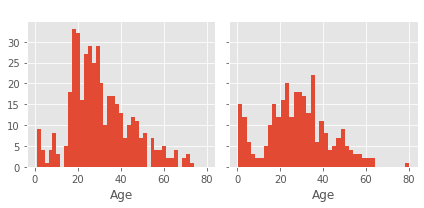

In [603]:
age_dist = sns.FacetGrid(train_data, col = "Survived")
age_dist.map(pyplot.hist, "Age", bins = 40)

## Parch and SibSp

We can now look and see whether the family of the passenger had any bearing on there survival probability.

In [604]:
train_data[["Parch","Survived"]].groupby(["Parch"]).mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


In [605]:
train_data[["SibSp","Survived"]].groupby(["SibSp"]).mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


As can be seen there is no correlation between the family connections and the survival probability.

## Embarkment

Now we can inspect whether the location which the passenger embarks onto the ship from affects survivability. As we know that the passenger class and sex already affects survivability, we shall include these parameters inot our visualisations. 

C:\Users\chira\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\chira\Anaconda3\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\chira\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\chira\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` i

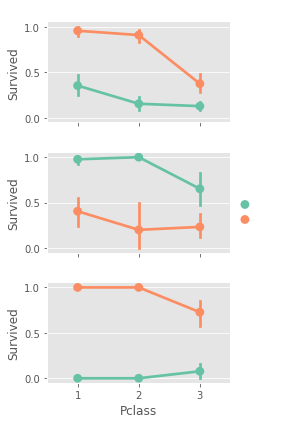

In [606]:
grid = sns.FacetGrid(train_data, row='Embarked', height=2, aspect=1.8)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='Set2')
grid.add_legend()

# Creating and Completing Features

## Mapping the Sex Feature

We start by converting features which are strings or other objects into integers or floats. We can do this firstly with the sex of the passengers.

In [607]:
train_data["Sex"] = train_data["Sex"].map({"female" : 1, "male" : 0})
test_data["Sex"] = test_data["Sex"].map({"female" : 1, "male" : 0})
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S


## Family Size

It may also make sense to create a new feature which tracks the family Size of the passenger and see whether it has any correlation to the survival probability

In [608]:
train_data["Family Size"] = train_data["SibSp"]+ train_data["Parch"] + 1
test_data["Family Size"] = test_data["SibSp"] + test_data["Parch"] + 1
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family Size
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,1


In [609]:
train_data[["Family Size","Survived"]].groupby(["Family Size"]).mean()

,Survived
Family Size,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


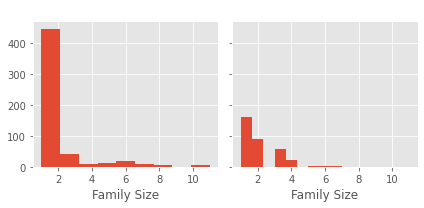

In [610]:
family_dist = sns.FacetGrid(train_data, col = "Survived")
family_dist.map(pyplot.hist, "Family Size", bins = 9)

## Completing and Banding the Age Feature

Now we will attempt to complete the features which are missing in the datasets.

In [611]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     889 non-null    object 
 10  Family Size  891 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 76.7+ KB


As can be seen the "Age" feature is mostly complete however it does contain some NaNs. To complete this feature we could use the "Sex" and "Pclass" features to attempt to fill out the feature by using the others to calculate a mean.   

In [612]:
train_mean_ages = np.zeros((2,3))

for i in range(0,2):
    for j in range(0,3):
        train_mean_age = train_data[(train_data["Sex"] == i) & (train_data["Pclass"] == j+1)]
        train_mean_age = train_mean_age[["Age"]].mean(skipna = True)
        train_mean_ages[i,j] = int(round(train_mean_age))
train_mean_ages

array([[41., 31., 27.],
       [35., 29., 22.]])

Here we have created an array which contains the mean ages for passengers of each gender and class.

In [613]:
for i in range(0,2):
    for j in range(0,3):
        train_data.loc[ (train_data.Age.isnull()) & (train_data.Sex == i) & (train_data.Pclass == j+1),['Age']] = train_mean_ages[i,j]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     889 non-null    object 
 10  Family Size  891 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 76.7+ KB


Here we filled the train datasets NaNs with the correct mean ages which we calculated from the other features, we will now repeat this process for the test dataset.

In [614]:
test_mean_ages = np.zeros((2,3))
for i in range(0,2):
    for j in range(0,3):
        test_mean_age = test_data[(test_data["Sex"] == i) & (test_data["Pclass"] == j+1)]
        test_mean_age = test_mean_age[["Age"]].mean(skipna = True)
        test_mean_ages[i,j] = int(round(test_mean_age))

for i in range(0,2):
    for j in range(0,3):
        test_data.loc[ (test_data.Age.isnull()) & (test_data.Sex == i) & (test_data.Pclass == j+1),['Age']] = test_mean_ages[i,j]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Fare         417 non-null    float64
 8   Embarked     418 non-null    object 
 9   Family Size  418 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 32.8+ KB


Now we band the age groups for both datasets.

In [615]:
train_data["Age Band"] = pd.cut(train_data["Age"], 5)
test_data["Age Band"] = pd.cut(test_data["Age"], 5)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family Size,Age Band
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,2,"(16.336, 32.252]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,2,"(32.252, 48.168]"
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,1,"(16.336, 32.252]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,2,"(32.252, 48.168]"
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,1,"(32.252, 48.168]"


In [616]:
ord_enc = OrdinalEncoder()
train_data["Age Band Encode"] = ord_enc.fit_transform(train_data[["Age Band"]])
test_data["Age Band Encode"] = ord_enc.fit_transform(test_data[["Age Band"]])
train_data[["Age Band","Age Band Encode"]].head(15)

,Age Band,Age Band Encode
0,"(16.336, 32.252]",1.0
1,"(32.252, 48.168]",2.0
2,"(16.336, 32.252]",1.0
3,"(32.252, 48.168]",2.0
4,"(32.252, 48.168]",2.0
5,"(16.336, 32.252]",1.0
6,"(48.168, 64.084]",3.0
7,"(0.34, 16.336]",0.0
8,"(16.336, 32.252]",1.0
9,"(0.34, 16.336]",0.0


## Completing the Embarkation Feature

The categorical feature Embarked is incomplete as can be seen in the info section below so we shall simply fill the NaNs with the most frequently occuring category.

In [617]:
train_data.info()
print("=" * 40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      891 non-null    int64   
 1   Survived         891 non-null    int64   
 2   Pclass           891 non-null    int64   
 3   Name             891 non-null    object  
 4   Sex              891 non-null    int64   
 5   Age              891 non-null    float64 
 6   SibSp            891 non-null    int64   
 7   Parch            891 non-null    int64   
 8   Fare             891 non-null    float64 
 9   Embarked         889 non-null    object  
 10  Family Size      891 non-null    int64   
 11  Age Band         891 non-null    category
 12  Age Band Encode  891 non-null    float64 
dtypes: category(1), float64(3), int64(7), object(2)
memory usage: 84.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Colu

Only the training dataset needs to be completed.

In [618]:
most_frequent = test_data.Embarked.mode()[0]
most_frequent

'S'

With Southampton being the port most frequently embarked from.

In [619]:
train_data["Embarked"] = train_data["Embarked"].fillna(most_frequent)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      891 non-null    int64   
 1   Survived         891 non-null    int64   
 2   Pclass           891 non-null    int64   
 3   Name             891 non-null    object  
 4   Sex              891 non-null    int64   
 5   Age              891 non-null    float64 
 6   SibSp            891 non-null    int64   
 7   Parch            891 non-null    int64   
 8   Fare             891 non-null    float64 
 9   Embarked         891 non-null    object  
 10  Family Size      891 non-null    int64   
 11  Age Band         891 non-null    category
 12  Age Band Encode  891 non-null    float64 
dtypes: category(1), float64(3), int64(7), object(2)
memory usage: 84.8+ KB


Now we encode the embarkation feature.

In [620]:
train_data["Embarked"] = ord_enc.fit_transform(train_data[["Embarked"]])
test_data["Embarked"] = ord_enc.fit_transform(test_data[["Embarked"]])
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family Size,Age Band,Age Band Encode
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,2.0,2,"(16.336, 32.252]",1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,0.0,2,"(32.252, 48.168]",2.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,2.0,1,"(16.336, 32.252]",1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,2.0,2,"(32.252, 48.168]",2.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,2.0,1,"(32.252, 48.168]",2.0


## Banding and Encoding the Fare Feature

We use the same process as seen for the age band to band and encode the Fare feature. However first we must complete the Fare feature in the test data set.

In [621]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      418 non-null    int64   
 1   Pclass           418 non-null    int64   
 2   Name             418 non-null    object  
 3   Sex              418 non-null    int64   
 4   Age              418 non-null    float64 
 5   SibSp            418 non-null    int64   
 6   Parch            418 non-null    int64   
 7   Fare             417 non-null    float64 
 8   Embarked         418 non-null    float64 
 9   Family Size      418 non-null    int64   
 10  Age Band         418 non-null    category
 11  Age Band Encode  418 non-null    float64 
dtypes: category(1), float64(4), int64(6), object(1)
memory usage: 36.7+ KB


In [622]:
test_data[(test_data["Fare"].isnull())]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family Size,Age Band,Age Band Encode
152,1044,3,"Storey, Mr. Thomas",0,60.5,0,0,NaN,2.0,1,"(45.668, 60.834]",3.0


As we can see this is a third class passenger embarking from Port = 2 . Therefore we can find the most frequent fare for this type of passenger and fill the feature with that value.

In [623]:
fare_mode = test_data[(test_data["Embarked"] == 2) & (test_data["Pclass"] == 3)]["Fare"].mode()
fare_mode

0    8.05
dtype: float64

In [624]:
test_data["Fare"] = train_data["Fare"].fillna(fare_mode)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      418 non-null    int64   
 1   Pclass           418 non-null    int64   
 2   Name             418 non-null    object  
 3   Sex              418 non-null    int64   
 4   Age              418 non-null    float64 
 5   SibSp            418 non-null    int64   
 6   Parch            418 non-null    int64   
 7   Fare             418 non-null    float64 
 8   Embarked         418 non-null    float64 
 9   Family Size      418 non-null    int64   
 10  Age Band         418 non-null    category
 11  Age Band Encode  418 non-null    float64 
dtypes: category(1), float64(4), int64(6), object(1)
memory usage: 36.7+ KB


Now we have completed the Fare feature, we can band and and turn it into ordinate categories, which is done as before. 

In [625]:
train_data["Fare Band"] = pd.cut(train_data["Fare"], 5)
test_data["Fare Band"] = pd.cut(test_data["Fare"], 5)
train_data["Fare Band"].unique()

[(-0.512, 102.466], (204.932, 307.398], (102.466, 204.932], (409.863, 512.329]]
Categories (4, interval[float64]): [(-0.512, 102.466] < (102.466, 204.932] < (204.932, 307.398] < (409.863, 512.329]]

In [626]:
train_data["Fare Band Encoded"] = ord_enc.fit_transform(train_data[["Fare Band"]])
test_data["Fare Band Encoded"] = ord_enc.fit_transform(test_data[["Fare Band"]])
train_data["Fare Band Encoded"].unique()

array([0., 2., 1., 3.])

In [627]:
train_data.info()
print("=" * 40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   PassengerId        891 non-null    int64   
 1   Survived           891 non-null    int64   
 2   Pclass             891 non-null    int64   
 3   Name               891 non-null    object  
 4   Sex                891 non-null    int64   
 5   Age                891 non-null    float64 
 6   SibSp              891 non-null    int64   
 7   Parch              891 non-null    int64   
 8   Fare               891 non-null    float64 
 9   Embarked           891 non-null    float64 
 10  Family Size        891 non-null    int64   
 11  Age Band           891 non-null    category
 12  Age Band Encode    891 non-null    float64 
 13  Fare Band          891 non-null    category
 14  Fare Band Encoded  891 non-null    float64 
dtypes: category(2), float64(5), int64(7), object(1)
memory us

## Cleaning Up

Now all the features are complete and have been transformed into some more useful forms. The redundent columns that we shall drop are:
* Name
* Age
* SibSp
* Parch
* Fare
* Family Size
* Age Band
* Fare Band

In [628]:
dropped_cols = ["PassengerId","Name","Age","SibSp","Parch","Fare","Age Band","Fare Band"]
test_ids = test_data["PassengerId"].copy()
train_data.drop(columns = dropped_cols, inplace = True)
test_data.drop(columns = dropped_cols, inplace = True)
train_data.info()
print("=" * 40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Survived           891 non-null    int64  
 1   Pclass             891 non-null    int64  
 2   Sex                891 non-null    int64  
 3   Embarked           891 non-null    float64
 4   Family Size        891 non-null    int64  
 5   Age Band Encode    891 non-null    float64
 6   Fare Band Encoded  891 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 48.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pclass             418 non-null    int64  
 1   Sex                418 non-null    int64  
 2   Embarked           418 non-null    float64
 3   Family Size        418 non-null    int64  
 4   Age Band Encode 

In [629]:
train_data.head(10)

,Survived,Pclass,Sex,Embarked,Family Size,Age Band Encode,Fare Band Encoded
0,0,3,0,2.0,2,1.0,0.0
1,1,1,1,0.0,2,2.0,0.0
2,1,3,1,2.0,1,1.0,0.0
3,1,1,1,2.0,2,2.0,0.0
4,0,3,0,2.0,1,2.0,0.0
5,0,3,0,1.0,1,1.0,0.0
6,0,1,0,2.0,1,3.0,0.0
7,0,3,0,2.0,5,0.0,0.0
8,1,3,1,2.0,3,1.0,0.0
9,1,2,1,0.0,2,0.0,0.0


# Machine Learning Algorithms

We first split the data sets into the feature we want to test ("Survived") and the features used to predict the outcome of the passenger

In [630]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data
X_train.shape, Y_train.shape, X_test.shape

((891, 6), (891,), (418, 6))

Once this has been done we can consider the different models we can utilise. This problem is a regression and classification problem which requires supervised learning which means the models which narrows down our selection of models. The models which will be considered are:
* Logistic Regression
* k-Nearest Neighbors
* Support Vector Machines
* Naive Bayes Classifier
* Decision Tree
* Random Forest
* Perceptron
* Stochastic Gradient Descent
* Gradient Boosting Classifier

## Logistic Regression

We can start with the logistic regression model as it is a fairly simple and lightweight algorithm.

In [631]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train,Y_train)
prediction = logistic_regression.predict(X_test)
logreg_acc = round(logistic_regression.score(X_train,Y_train) * 100, 2)
print(f"Logistic Regression Accuracy: {logreg_acc}%")

Logistic Regression Accuracy: 79.91%


An accuracy of ~80% is fairly reasonable for a rather simple algorithm.

## k-Nearest Neighbors

We can use the k-Nearest Neighbors classification algorithm, where we can vary the number of neighbors to try and find the optimal number. 

In [632]:
allAcc = []
n = np.linspace(1,19,10).astype(int)
bestAcc = 0
for number in n:
    knn = KNeighborsClassifier(n_neighbors = number)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    acc = round(knn.score(X_train, Y_train) * 100, 2)
    if acc > bestAcc:
        knn_acc = acc
        numOfNeighbors = number
    allAcc.append(acc)
print(f"Highest Accuracy is {knn_acc}% with {numOfNeighbors} neighbors")

Highest Accuracy is 81.37% with 19 neighbors


The max number of neighbors seems to be, we can observe how the accuracy changes due to the number of neighbors

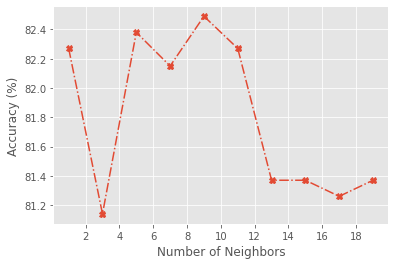

In [633]:
pyplot.style.use(['dark_background', 'ggplot'])
pyplot.plot(n,allAcc,"-.X")
pyplot.locator_params(axis="x", nbins = 10)
pyplot.xlabel("Number of Neighbors")
pyplot.ylabel("Accuracy (%)")
pyplot.show()

Here we can see that the accuracy generally increases until 13 neighbors and then it decreases once more. 

## Support Vector Machines

Next we can try using a Support Vector Machine.

In [634]:
svc = SVC()
svc.fit(X_train, Y_train)
svc_acc = round(svc.score(X_train, Y_train) * 100, 2)
print(f"Support Vector Machine Accuracy: {svc_acc}%")

Support Vector Machine Accuracy: 82.27%


We can also apply the linear SVC algorithm.

In [635]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
linear_svc_acc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print(f"Linear Support Vector Machine Accuracy: {linear_svc_acc}%")

Linear Support Vector Machine Accuracy: 80.25%


C:\Users\chira\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Naive Bayes Classifier

We can now try using the Naive Bayes Classifier.

In [636]:
nbc = GaussianNB()
nbc.fit(X_train,Y_train)
nbc_acc = round(nbc.score(X_train, Y_train) * 100, 2)
print(f"Naive Bayes Classifier Accuracy: {nbc_acc}%")

Naive Bayes Classifier Accuracy: 79.91%


## Decision Tree

Next we can try the decision tree algorithm.

In [637]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
decision_tree_acc = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(f"Decision Tree Accuracy: {decision_tree_acc}%")

Decision Tree Accuracy: 86.08%


## Random Forest

The Random Forest algorithm is an extension of the Decision Tree algorithm, as it creates an ensemble of randomly generated decision trees and then outputs the mean prediction of the decision trees.

In [638]:
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, Y_train)
random_forest.score(X_train, Y_train)
random_forest_acc = round(random_forest.score(X_train, Y_train) * 100, 2)
print(f"Random Forest Accuracy: {random_forest_acc}%")

Random Forest Accuracy: 86.08%


## Perceptron

We now try the Perceptron algorithm, which is a supervised learning classifier for binary classifiers.

In [639]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
perceptron_acc = round(perceptron.score(X_train, Y_train) * 100, 2)
print(f"Perceptron Accuracy: {perceptron_acc}%")

Perceptron Accuracy: 70.71%


## Stochastic Gradient Descent

We now apply the stochastic gradient descent algorithm

In [640]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
sgd_acc = round(sgd.score(X_train, Y_train) * 100, 2)
print(f"Stochastic Gradient Descent Accuracy: {sgd_acc}%")

Stochastic Gradient Descent Accuracy: 77.1%


## Gradient Boosting Classifier

Now we apply the Gradient Boosting Classifier.

In [641]:
gb = GradientBoostingClassifier()
gb.fit(X_train,Y_train)
gb_acc = round(gb.score(X_train,Y_train)*100, 2)
print(f"Gradient Boosting Classifier Accuracy: {gb_acc}%")

Gradient Boosting Classifier Accuracy: 84.29%


# Evaluation and Final Submission

We can create a Data Frame containing all the models and there respective accuracies to determine which is the most optimal to use for the submission.

In [642]:
models = pd.DataFrame({'Model': ["Logistic Regression","k-Nearest Neighbors","Support Vector Machine","Linear Support Vector Machine","Naive Bayes Classifier"
,"Decision Tree","Random Forest","Perceptron","Stochastic Gradient Descent","Gradient Boosting Classifier"],'Score': [logreg_acc,knn_acc,svc_acc,linear_svc_acc,nbc_acc,
decision_tree_acc,random_forest_acc,perceptron_acc,sgd_acc,gb_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
5,Decision Tree,86.08
6,Random Forest,86.08
9,Gradient Boosting Classifier,84.29
2,Support Vector Machine,82.27
1,k-Nearest Neighbors,81.37
3,Linear Support Vector Machine,80.25
0,Logistic Regression,79.91
4,Naive Bayes Classifier,79.91
8,Stochastic Gradient Descent,77.10
7,Perceptron,70.71


As we can see the Decision Tree and the Random Forest algorithms are the most successful so that is the algorithm which will be utilised in the submission

In [643]:
Y_pred = random_forest.predict(X_test)
submission = pd.DataFrame({"PassengerId": test_ids,"Survived": Y_pred})
submission.head(15)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


Now we need to write the submission to a CSV file.

In [644]:
submission.to_csv('C:/Users/chira/Documents/Python/ML/Titanic/submission.csv',index = False)